# Test Parameter Estimator

Test the ParameterEstimator class with a subset of experimental conditions and fitted parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from parameter_estimator import ParameterEstimator

## Load PETAb Data

In [2]:
# Load PETAb files
conditions_df = pd.read_csv('../petab_files/conditions.tsv', sep='\t')
measurements_df = pd.read_csv('../petab_files/measurements.tsv', sep='\t')
observables_df = pd.read_csv('../petab_files/observables.tsv', sep='\t')
parameters_df = pd.read_csv('../petab_files/parameters.tsv', sep='\t')

print(f"Original data:")
print(f"  {len(conditions_df)} experimental conditions")
print(f"  {len(measurements_df)} measurements")

Original data:
  6 experimental conditions
  84 measurements


## Create Parameter Estimator

In [3]:
# Create estimator with filtered data
estimator = ParameterEstimator(
    bngl_file="../variable_JAK_STAT_SOCS_degrad_model.bngl",
    conditions_df=conditions_df,
    measurements_df=measurements_df,
    observables_df=observables_df,
    parameters_df=parameters_df
)

print(f"\nEstimable parameters: {len(estimator.estimable_params)}")

Initialized estimator with 46 estimable parameters
Timepoints: [ 0. 10. 20. 30. 45. 60. 90.]

Estimable parameters: 46


## Load Fitted Parameters

In [4]:
# Load fitted parameter sets and remove duplicates
param_sets_df_full = pd.read_csv('../param_sets.csv')
print(f"Loaded {len(param_sets_df_full)} parameter sets (with redundancy)")

# L1_0 and L2_0 vary by condition, so exclude them when checking for duplicates
# We only want unique sets of the actual fitted parameters
cols_to_check = [col for col in param_sets_df_full.columns if col not in ['L1_0', 'L2_0']]
param_sets_df = param_sets_df_full.drop_duplicates(subset=cols_to_check).reset_index(drop=True)

print(f"Unique parameter sets: {len(param_sets_df)}")
print(f"Redundancy factor: {len(param_sets_df_full) / len(param_sets_df):.1f}x")

# Use first parameter set
fitted_dict = param_sets_df.iloc[0].to_dict()

# Create parameter dict for estimator (only estimable params)
fitted_dict_subset = {}
for param_name in estimator.estimable_params:
    if param_name in fitted_dict:
        fitted_dict_subset[param_name] = fitted_dict[param_name]
    else:
        # Use nominal value for missing parameters
        fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']

print(f"\nParameter set 0 loaded")
print(f"Sample parameters:")
for i, (param, value) in enumerate(list(fitted_dict_subset.items())[:5]):
    print(f"  {param}: {value:.6g}")
print(f"  ...")

Loaded 12402 parameter sets (with redundancy)
Unique parameter sets: 2067
Redundancy factor: 6.0x

Parameter set 0 loaded
Sample parameters:
  il10_complex_jak1_binding: 259.69
  SOCS3_il6r_unbinding: 0.39669
  il6_jak1_med_STAT1_act: 2.32e-05
  pSTAT1_rec_dissoc: 1.0407
  il6_complex_jak2_binding: 0.026832
  ...


## Convert to Parameter Vector and Compute NLLH

In [5]:
# Convert to parameter vector
fitted_vector = estimator.params_to_vector(fitted_dict_subset)

print("Computing negative log-likelihood...")
nllh = estimator.compute_nllh(fitted_vector, verbose=True)
print(f"\nNegative log-likelihood: {nllh:.4f}")

Computing negative log-likelihood...
Computed scaling factors: sf_pSTAT1=27065.25, sf_pSTAT3=281.03
NLLH = -107.7316 (84 datapoints)

Negative log-likelihood: -107.7316


## Plot Fit vs Data

Visualize model predictions vs experimental data for all 6 conditions.

In [6]:
# Evaluate NLLH for multiple parameter sets
import time

# Choose how many parameter sets to evaluate
n_sets_to_evaluate = 100 #2067  # Adjust this number as needed

print(f"Evaluating NLLH for {n_sets_to_evaluate} parameter sets...")
print(f"Total available: {len(param_sets_df)} parameter sets\n")

nllh_values = []
param_set_indices = []
failed_indices = []

start_time = time.time()

for idx in range(min(n_sets_to_evaluate, len(param_sets_df))):
    # Get parameter set
    fitted_dict = param_sets_df.iloc[idx].to_dict()
    
    # Create parameter dict for estimator (only estimable params, no sf_ or sigma_)
    fitted_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in fitted_dict:
            fitted_dict_subset[param_name] = fitted_dict[param_name]
        else:
            # Use nominal value for missing parameters
            fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    # Convert to parameter vector
    try:
        param_vector = estimator.params_to_vector(fitted_dict_subset)
        
        # Compute NLLH
        nllh = estimator.compute_nllh(param_vector, verbose=False)
        
        if np.isfinite(nllh):
            nllh_values.append(nllh)
            param_set_indices.append(idx)
        else:
            failed_indices.append(idx)
            
    except Exception as e:
        print(f"Error evaluating parameter set {idx}: {e}")
        failed_indices.append(idx)
    
    # Progress update every 10 sets
    if (idx + 1) % 10 == 0:
        elapsed = time.time() - start_time
        rate = (idx + 1) / elapsed
        remaining = (n_sets_to_evaluate - idx - 1) / rate
        print(f"  Completed {idx + 1}/{n_sets_to_evaluate} ({100*(idx+1)/n_sets_to_evaluate:.1f}%) - "
              f"Est. time remaining: {remaining:.1f}s")

elapsed_time = time.time() - start_time

print(f"\n{'='*60}")
print(f"Evaluation complete!")
print(f"  Total time: {elapsed_time:.1f} seconds")
print(f"  Successful: {len(nllh_values)}/{n_sets_to_evaluate}")
print(f"  Failed: {len(failed_indices)}/{n_sets_to_evaluate}")
print(f"\nNLLH Statistics:")
print(f"  Min:    {np.min(nllh_values):.2f}")
print(f"  Median: {np.median(nllh_values):.2f}")
print(f"  Mean:   {np.mean(nllh_values):.2f}")
print(f"  Max:    {np.max(nllh_values):.2f}")
print(f"  Std:    {np.std(nllh_values):.2f}")

# Find best parameter set
best_idx = param_set_indices[np.argmin(nllh_values)]
best_nllh = np.min(nllh_values)
print(f"\nBest parameter set: #{best_idx} with NLLH = {best_nllh:.2f}")

Evaluating NLLH for 100 parameter sets...
Total available: 2067 parameter sets

  Completed 10/100 (10.0%) - Est. time remaining: 4.5s
  Completed 20/100 (20.0%) - Est. time remaining: 3.8s
  Completed 30/100 (30.0%) - Est. time remaining: 3.4s
  Completed 40/100 (40.0%) - Est. time remaining: 3.0s
  Completed 50/100 (50.0%) - Est. time remaining: 2.5s
  Completed 60/100 (60.0%) - Est. time remaining: 2.0s
  Completed 70/100 (70.0%) - Est. time remaining: 1.5s
  Completed 80/100 (80.0%) - Est. time remaining: 1.0s
  Completed 90/100 (90.0%) - Est. time remaining: 0.5s
  Completed 100/100 (100.0%) - Est. time remaining: 0.0s

Evaluation complete!
  Total time: 4.8 seconds
  Successful: 100/100
  Failed: 0/100

NLLH Statistics:
  Min:    -132.13
  Median: -72.64
  Mean:   -70.61
  Max:    59.50
  Std:    30.06

Best parameter set: #30 with NLLH = -132.13


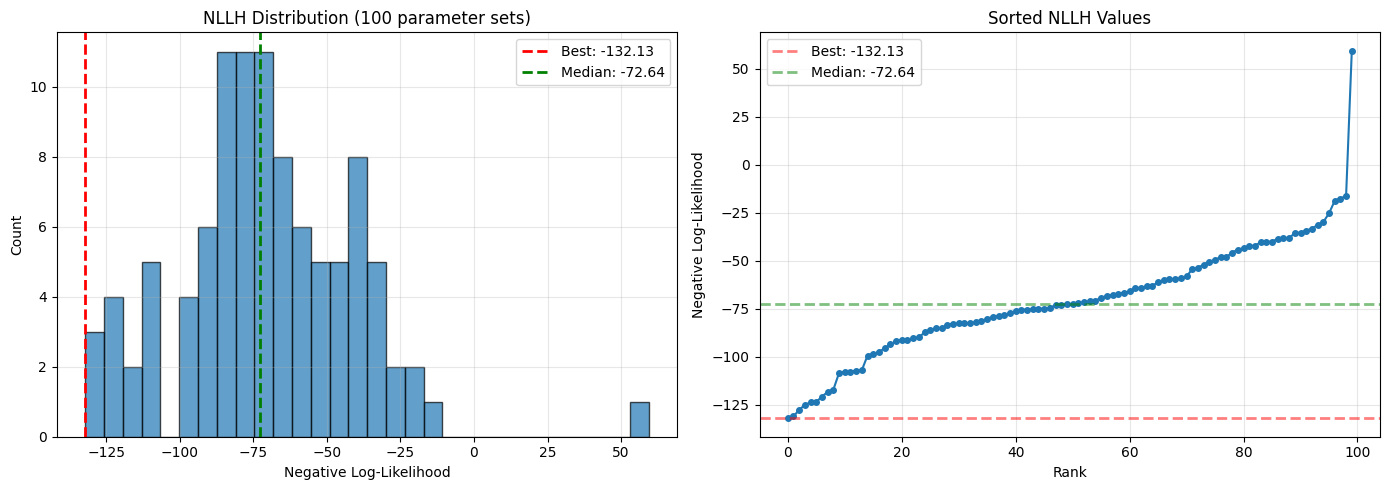


Top 10 parameter sets (lowest NLLH):
   1. Parameter set #  30: NLLH = -132.13
   2. Parameter set #  29: NLLH = -131.08
   3. Parameter set #   2: NLLH = -127.72
   4. Parameter set #  28: NLLH = -125.06
   5. Parameter set #   3: NLLH = -123.83
   6. Parameter set #  26: NLLH = -123.56
   7. Parameter set #  10: NLLH = -120.78
   8. Parameter set #  31: NLLH = -118.32
   9. Parameter set #   5: NLLH = -117.16
  10. Parameter set #   8: NLLH = -108.49


In [7]:
# Plot NLLH distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(nllh_values, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(best_nllh, color='red', linestyle='--', linewidth=2, label=f'Best: {best_nllh:.2f}')
ax.axvline(np.median(nllh_values), color='green', linestyle='--', linewidth=2, 
           label=f'Median: {np.median(nllh_values):.2f}')
ax.set_xlabel('Negative Log-Likelihood')
ax.set_ylabel('Count')
ax.set_title(f'NLLH Distribution ({len(nllh_values)} parameter sets)')
ax.legend()
ax.grid(True, alpha=0.3)

# Sorted NLLH values
ax = axes[1]
sorted_nllh = np.sort(nllh_values)
ax.plot(range(len(sorted_nllh)), sorted_nllh, 'o-', markersize=4)
ax.axhline(best_nllh, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'Best: {best_nllh:.2f}')
ax.axhline(np.median(nllh_values), color='green', linestyle='--', linewidth=2, alpha=0.5,
           label=f'Median: {np.median(nllh_values):.2f}')
ax.set_xlabel('Rank')
ax.set_ylabel('Negative Log-Likelihood')
ax.set_title('Sorted NLLH Values')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTop 10 parameter sets (lowest NLLH):")
top_10_idx = np.argsort(nllh_values)[:10]
for rank, idx in enumerate(top_10_idx, 1):
    param_idx = param_set_indices[idx]
    nllh_val = nllh_values[idx]
    print(f"  {rank:2d}. Parameter set #{param_idx:4d}: NLLH = {nllh_val:.2f}")

Plotting best parameter set (#30) with NLLH = -132.13

Plotting fit for 6 conditions


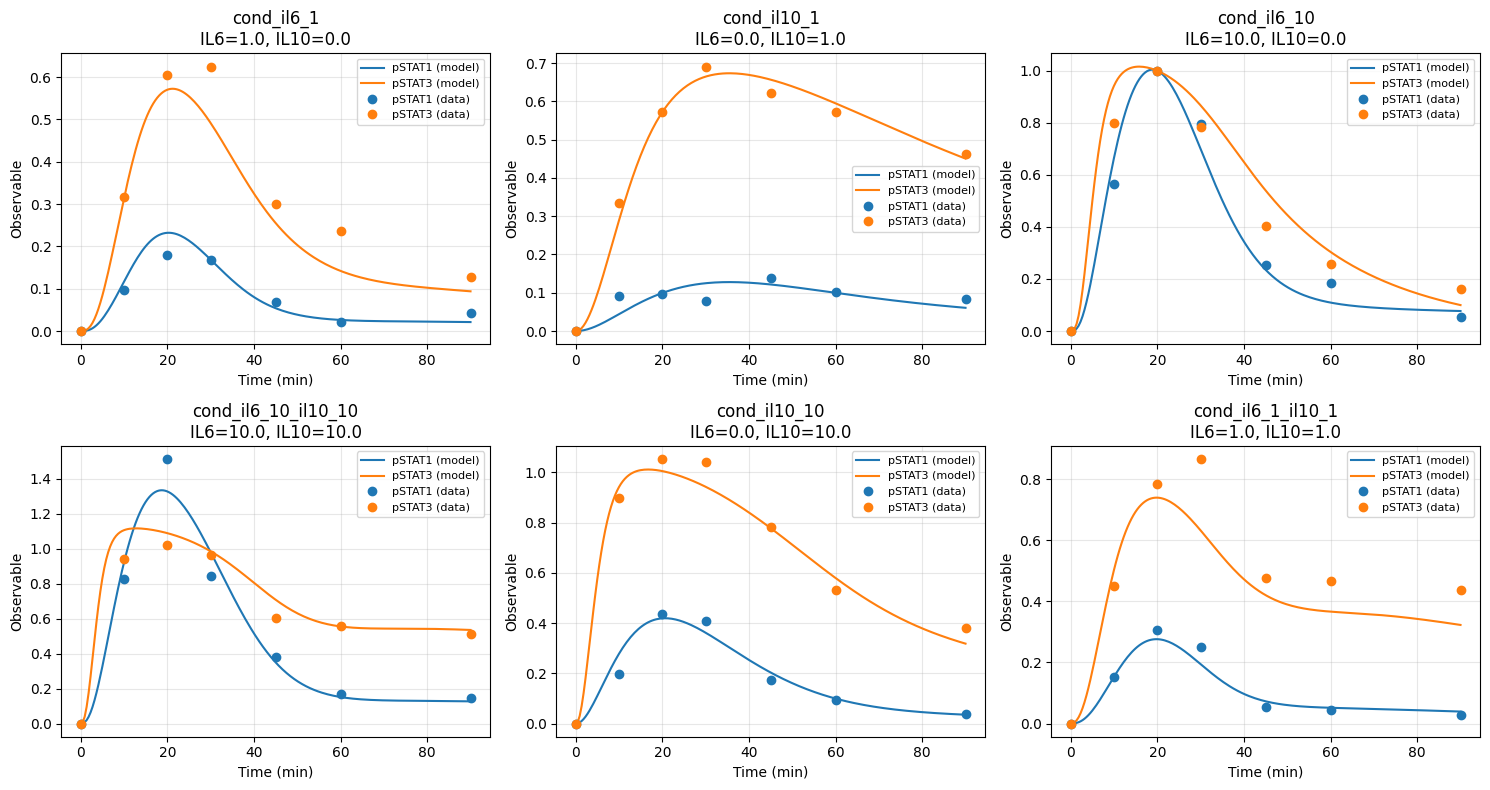

In [8]:
# Plot the best fit
print(f"Plotting best parameter set (#{best_idx}) with NLLH = {best_nllh:.2f}\n")

# Get best parameter set
best_fitted_dict = param_sets_df.iloc[best_idx].to_dict()
best_fitted_dict_subset = {}
for param_name in estimator.estimable_params:
    if param_name in best_fitted_dict:
        best_fitted_dict_subset[param_name] = best_fitted_dict[param_name]
    else:
        best_fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']

# Convert to vector
best_param_vector = estimator.params_to_vector(best_fitted_dict_subset)

# Plot the fit
estimator.plot_fit(best_param_vector)

## Compare with Best Fit from bestfit.csv

Compare the best fit from the external optimization with parameter sets from param_sets.csv

Loaded best fit with 46 parameters

Computed scaling factors: sf_pSTAT1=0.96, sf_pSTAT3=1.06
NLLH = -104.4503 (84 datapoints)

Best fit NLLH: -104.45



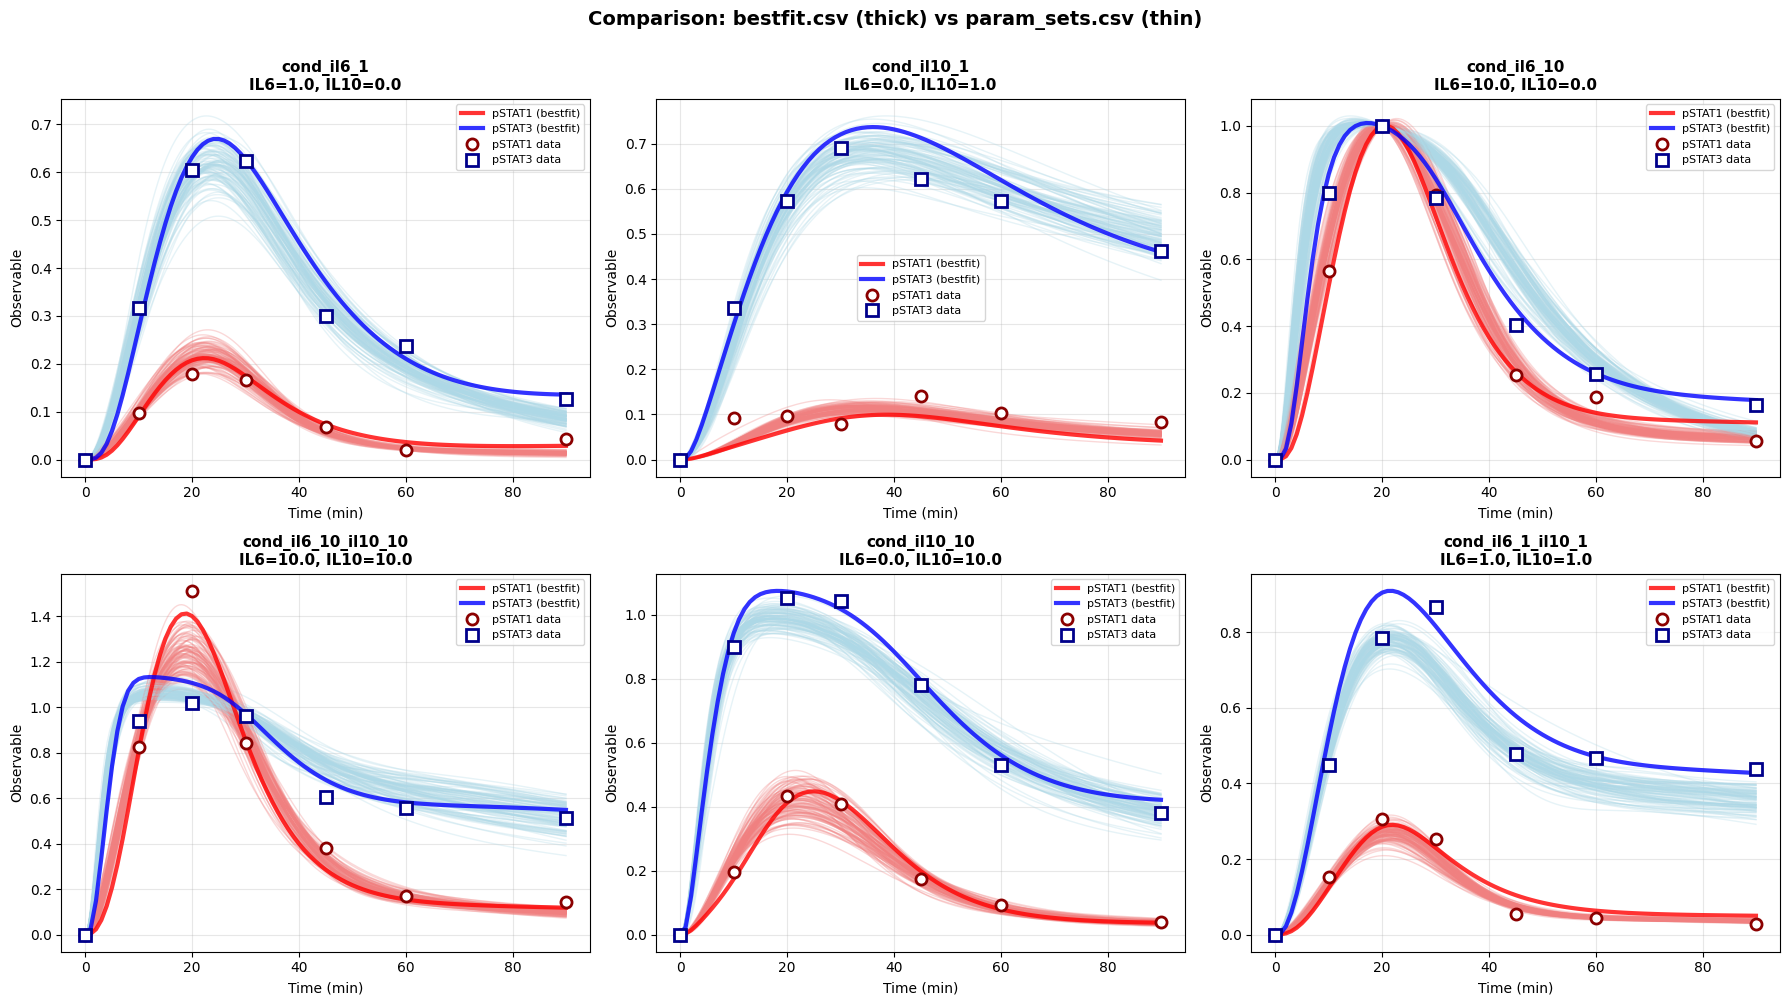


SUMMARY
Source                     NLLH    sf_pSTAT1    sf_pSTAT3
----------------------------------------------------------------------
bestfit.csv             -104.45          1.0          1.1
----------------------------------------------------------------------
param_sets #1692         -70.02        255.1         49.4
param_sets #1463         -76.30        119.7         84.8
param_sets #1381         -89.44         41.0        149.4
param_sets #1114         -63.19        112.3        360.4
param_sets #578          -79.56        449.3         87.5
param_sets #1626         -99.24        714.7         64.3
param_sets #861          -61.00        159.1         69.0
param_sets #675          -75.59        172.5         82.5
param_sets #69           -33.24       9141.4        925.5
param_sets #117          -42.97       6155.6        368.1
param_sets #1108         -62.36        100.5        264.1
param_sets #1997        -112.84        657.1         69.5
param_sets #150          -51.86      

In [ ]:
# Load bestfit.csv and compare with param_sets.csv results
import matplotlib.pyplot as plt

# Load bestfit parameters (already in log10 space)
bestfit_df = pd.read_csv('bestfit.csv')
print(f"Loaded best fit with {len(bestfit_df)} parameters\n")

# Create parameter vector from bestfit.csv
# The values are already in estimation space (log10)
bestfit_vector = np.zeros(len(estimator.estimable_params))
for i, param_name in enumerate(estimator.estimable_params):
    param_row = bestfit_df[bestfit_df['parameter'] == param_name]
    if len(param_row) > 0:
        bestfit_vector[i] = param_row['value'].values[0]
    else:
        # Use nominal value if parameter not in bestfit
        print(f"Warning: {param_name} not in bestfit.csv, using nominal value")
        nominal = estimator.param_info[param_name]['nominal']
        if estimator.param_info[param_name]['scale'] == 'log10':
            bestfit_vector[i] = np.log10(nominal)
        else:
            bestfit_vector[i] = nominal

# Compute NLLH for bestfit
bestfit_nllh = estimator.compute_nllh(bestfit_vector, verbose=True)
print(f"\nBest fit NLLH: {bestfit_nllh:.2f}\n")

# Compare with top 3 parameter sets from param_sets.csv
#indices_to_compare = [29, 1033, 138]  # Same as before
# 100 random sets from param_sets.csv
indices_to_compare = np.random.choice(len(param_sets_df), size=100, replace=False)

# Simulate param_sets FIRST
all_results = []
all_scaling_factors = []
all_nllh = []

for idx in indices_to_compare:
    fitted_dict = param_sets_df.iloc[idx].to_dict()
    fitted_dict_subset = {}
    for param_name in estimator.estimable_params:
        if param_name in fitted_dict:
            fitted_dict_subset[param_name] = fitted_dict[param_name]
        else:
            fitted_dict_subset[param_name] = estimator.param_info[param_name]['nominal']
    
    param_vector = estimator.params_to_vector(fitted_dict_subset)
    results, (sf_pSTAT1, sf_pSTAT3) = estimator.simulate_conditions(param_vector)
    nllh = estimator.compute_nllh(param_vector, verbose=False)
    
    all_results.append(results)
    all_scaling_factors.append((sf_pSTAT1, sf_pSTAT3))
    all_nllh.append(nllh)

# Now simulate bestfit and INSERT at the beginning
bestfit_results, (bestfit_sf_pSTAT1, bestfit_sf_pSTAT3) = estimator.simulate_conditions(bestfit_vector, n_steps=91)
all_results.insert(0, bestfit_results)
all_scaling_factors.insert(0, (bestfit_sf_pSTAT1, bestfit_sf_pSTAT3))
all_nllh.insert(0, bestfit_nllh)

# Create figure with subplots for each condition
n_conditions = len(conditions_df)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each condition
for cond_idx, cond_id in enumerate(conditions_df['conditionId']):
    ax = axes[cond_idx]
    
    # Get condition info
    cond_row = conditions_df[conditions_df['conditionId'] == cond_id].iloc[0]
    
    # Plot param_sets results first (thin lines, in background)
    for i in range(1, len(all_results)):
        results = all_results[i]
        sf_pSTAT1, sf_pSTAT3 = all_scaling_factors[i]
        
        # Plot pSTAT1 (light red, thin)
        ax.plot(results[cond_id]['time'], sf_pSTAT1 * results[cond_id]['total_pS1'],
               '-', color='lightcoral', alpha=0.3, linewidth=1.0)
        # Plot pSTAT3 (light blue, thin)
        ax.plot(results[cond_id]['time'], sf_pSTAT3 * results[cond_id]['total_pS3'],
               '-', color='lightblue', alpha=0.3, linewidth=1.0)
    
    # Plot bestfit result (thick lines, on top)
    results = all_results[0]
    sf_pSTAT1, sf_pSTAT3 = all_scaling_factors[0]
    
    # Plot pSTAT1 (red, thick)
    ax.plot(results[cond_id]['time'], sf_pSTAT1 * results[cond_id]['total_pS1'],
           '-', color='red', alpha=0.8, linewidth=3.0, label='pSTAT1 (bestfit)')
    # Plot pSTAT3 (blue, thick)
    ax.plot(results[cond_id]['time'], sf_pSTAT3 * results[cond_id]['total_pS3'],
           '-', color='blue', alpha=0.8, linewidth=3.0, label='pSTAT3 (bestfit)')
    
    # Overlay experimental data
    cond_data = measurements_df[measurements_df['simulationConditionId'] == cond_id]
    
    # pSTAT1 data
    pS1_data = cond_data[cond_data['observableId'] == 'obs_total_pS1']
    if len(pS1_data) > 0:
        ax.plot(pS1_data['time'], pS1_data['measurement'],
               'o', color='darkred', markersize=8, markeredgewidth=2,
               markerfacecolor='white', label='pSTAT1 data', zorder=10)
    
    # pSTAT3 data
    pS3_data = cond_data[cond_data['observableId'] == 'obs_total_pS3']
    if len(pS3_data) > 0:
        ax.plot(pS3_data['time'], pS3_data['measurement'],
               's', color='darkblue', markersize=8, markeredgewidth=2,
               markerfacecolor='white', label='pSTAT3 data', zorder=10)
    
    ax.set_title(f"{cond_id}\nIL6={cond_row['L1_0']}, IL10={cond_row['L2_0']}", 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (min)', fontsize=10)
    ax.set_ylabel('Observable', fontsize=10)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison: bestfit.csv (thick) vs param_sets.csv (thin)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"{'Source':<20} {'NLLH':>10} {'sf_pSTAT1':>12} {'sf_pSTAT3':>12}")
print("-"*70)
sf1, sf3 = all_scaling_factors[0]
print(f"{'bestfit.csv':<20} {all_nllh[0]:>10.2f} {sf1:>12.1f} {sf3:>12.1f}")
print("-"*70)
for i, idx in enumerate(indices_to_compare, start=1):
    sf1, sf3 = all_scaling_factors[i]
    print(f"{'param_sets #' + str(idx):<20} {all_nllh[i]:>10.2f} {sf1:>12.1f} {sf3:>12.1f}")
print("="*70)
best_idx = np.argmin(all_nllh)
label = 'bestfit.csv' if best_idx == 0 else f'param_sets #{indices_to_compare[best_idx-1]}'
print(f"\nBest NLLH: {all_nllh[best_idx]:.2f} from {label}")

In [12]:
# Save trajectories from bestfit to CSV
# Using the bestfit results (all_results[0])

trajectory_data = []

for cond_id in conditions_df['conditionId']:
    # Get simulation results for this condition
    sim_result = all_results[0][cond_id]
    sf_pSTAT1, sf_pSTAT3 = all_scaling_factors[0]
    
    # Get timepoints
    timepoints = sim_result['time']
    print(f"Condition {cond_id}: {len(timepoints)} timepoints")
    
    # Add pSTAT1 trajectory
    pSTAT1_values = sf_pSTAT1 * sim_result['total_pS1']
    for t, value in zip(timepoints, pSTAT1_values):
        trajectory_data.append({
            'condition': cond_id,
            'observable': 'pSTAT1',
            'time': t,
            'value': value
        })
    
    # Add pSTAT3 trajectory
    pSTAT3_values = sf_pSTAT3 * sim_result['total_pS3']
    for t, value in zip(timepoints, pSTAT3_values):
        trajectory_data.append({
            'condition': cond_id,
            'observable': 'pSTAT3',
            'time': t,
            'value': value
        })

# Create DataFrame and save to CSV
trajectories_df = pd.DataFrame(trajectory_data)
trajectories_df.to_csv('bestfit_trajectories.csv', index=False)

print(f"Saved trajectories to bestfit_trajectories.csv")
print(f"Total rows: {len(trajectories_df)}")
print(f"\nFirst few rows:")
print(trajectories_df.head(10))

Condition cond_il6_1: 91 timepoints
Condition cond_il10_1: 91 timepoints
Condition cond_il6_10: 91 timepoints
Condition cond_il6_10_il10_10: 91 timepoints
Condition cond_il10_10: 91 timepoints
Condition cond_il6_1_il10_1: 91 timepoints
Saved trajectories to bestfit_trajectories.csv
Total rows: 1092

First few rows:
    condition observable  time     value
0  cond_il6_1     pSTAT1   0.0  0.000000
1  cond_il6_1     pSTAT1   1.0  0.000099
2  cond_il6_1     pSTAT1   2.0  0.001135
3  cond_il6_1     pSTAT1   3.0  0.004226
4  cond_il6_1     pSTAT1   4.0  0.010012
5  cond_il6_1     pSTAT1   5.0  0.018614
6  cond_il6_1     pSTAT1   6.0  0.029792
7  cond_il6_1     pSTAT1   7.0  0.043095
8  cond_il6_1     pSTAT1   8.0  0.057982
9  cond_il6_1     pSTAT1   9.0  0.073903
